In [1]:
# 对原始五个角度的牙齿图片进行放缩，统一尺寸，方便进行数据标注（描边牙齿轮廓）
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
import time
import cv2
import copy
import skimage
import enum
import h5py

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
PHOTO_PATH = r"./dataWithPhoto/normal/" 
DST_PATH = r"./dataWithPhoto/normal_resized/" 

In [3]:
def getPhotoShapes(photo_path):
    photoFiles = glob.glob(os.path.join(photo_path, "*.jpg"))
    photoShapes = []
    for photoFile in photoFiles:
        photo = skimage.io.imread(photoFile, as_gray=True)
        photoShapes.append(photo.shape)
    return photoShapes

In [4]:
photoShapes = getPhotoShapes(PHOTO_PATH)

In [5]:
photoShapeArray = np.array(photoShapes)
print("mean photo shape: ", photoShapeArray.mean(axis=0))
print("max photo shape: ", photoShapeArray.max(axis=0))
print("min photo shape: ", photoShapeArray.min(axis=0))

mean photo shape:  [1275.88210526 1713.60421053]
max photo shape:  [2543 3391]
min photo shape:  [464 765]


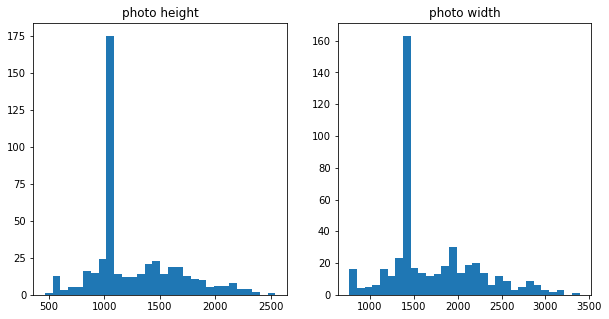

In [6]:
# 照片尺寸（长度，宽度）直方分布图
bins = 30
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(photoShapeArray[:,0], bins=bins)
plt.title("photo height")
plt.subplot(122)
plt.hist(photoShapeArray[:,1], bins=bins)
plt.title("photo width")
plt.show()

In [7]:
# resize photo 
def resizePhotos(src_path, dst_path, resized_width=1440, resized_height=1080, save_format="png"):
    srcPhotoFiles = glob.glob(os.path.join(src_path, "*.jpg"))
    for photoFile in srcPhotoFiles:
        # if not "_219376_" in os.path.basename(photoFile):
        #     continue
        photo = skimage.io.imread(photoFile, as_gray=False)
        _, _, channel = photo.shape
        if channel > 3:
            photo = skimage.color.rgba2rgb(photo)
        rescale_w = resized_width / photo.shape[1]
        rescale_h = resized_height / photo.shape[0]
        padFlag = np.abs(photo.shape[0]/photo.shape[1] - resized_height/resized_width) > 0.05
        if padFlag == True:
            rescale = np.min([rescale_w, rescale_h])
            photo = skimage.transform.rescale(photo, rescale, channel_axis=2, anti_aliasing=True) # shape approx ~ (1080,1440,3)
            h, w = photo.shape[:2]
            print(h,w)
            pad_top = (resized_height-h)//2
            pad_bottom = resized_height - h - pad_top
            pad_left = (resized_width-w)//2
            pad_right = resized_width - w - pad_left
            photo = cv2.copyMakeBorder(photo, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0,0,0)) # 用黑色适当填充边框
        else:
            rescale = np.max([rescale_w, rescale_h]) 
            photo = skimage.transform.rescale(photo, rescale, channel_axis=2, anti_aliasing=True) # shape approx ~ (1080,1440,3)
            if photo.shape[0] > resized_height or photo.shape[1] > resized_width: # 适当裁切
                photo = photo[:resized_height, :resized_width]
        print(photoFile, photo.shape)
        dstPhotoFile = os.path.join(dst_path, os.path.splitext(os.path.basename(photoFile))[0] + "." + save_format)
        skimage.io.imsave(dstPhotoFile, (255.*photo).astype(np.uint8))

In [8]:
resizePhotos(src_path=PHOTO_PATH, dst_path=DST_PATH, resized_width=1440, resized_height=1080, save_format="png")

./dataWithPhoto/normal\侯萱烨_219376_上牙列.jpg (1080, 1440, 3)
./dataWithPhoto/normal\侯萱烨_219376_下牙列.jpg (1080, 1440, 3)
./dataWithPhoto/normal\侯萱烨_219376_右侧咬合.jpg (1080, 1440, 3)
./dataWithPhoto/normal\侯萱烨_219376_左侧咬合.jpg (1080, 1440, 3)
./dataWithPhoto/normal\侯萱烨_219376_正位像.jpg (1080, 1440, 3)
